In [1]:
import os, math, random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision as tv
import torchvision.transforms as T
import matplotlib.pyplot as plt

# -----------------------------
# Setup & Transforms
# -----------------------------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.RandomResizedCrop(64),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_tf = T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

dataset_path = "./tiny-imagenet-200"
if not os.path.exists(dataset_path):
    os.system("wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O tiny-imagenet.zip")
    os.system("unzip tiny-imagenet.zip -d ./")
    print("Tiny ImageNet downloaded and unzipped.")

# -----------------------------
# Load train/val datasets
# -----------------------------
full_train_set = tv.datasets.ImageFolder(os.path.join(dataset_path, "train"), transform=train_tf)

# Tiny ImageNet val: fix labels using annotations
val_annotations_file = os.path.join(dataset_path, "val", "val_annotations.txt")
val_img_to_label = {}
with open(val_annotations_file) as f:
    for line in f:
        parts = line.strip().split("\t")
        val_img_to_label[parts[0]] = parts[1]

full_val_set = tv.datasets.ImageFolder(os.path.join(dataset_path, "val"), transform=val_tf)
# Replace val labels to match train class_to_idx
val_samples = []
for path, _ in full_val_set.samples:
    img_name = os.path.basename(path)
    wnid = val_img_to_label[img_name]
    label = full_train_set.class_to_idx[wnid]
    val_samples.append((path, label))
full_val_set.samples = val_samples
full_val_set.targets = [lbl for _, lbl in val_samples]

# -----------------------------
# Pick 20 classes ONCE and build mapping to 0..19
# -----------------------------
all_classes = full_train_set.classes  # list of wnids length 200
selected_classes = sorted(random.sample(all_classes, 20))  # sort for determinism
orig_to_new = {full_train_set.class_to_idx[c]: i for i, c in enumerate(selected_classes)}

# -----------------------------
# Filter indices to selected classes (using samples metadata, no transforms)
# -----------------------------
def filter_indices_by_classes(dataset, classes_new_map):
    keep = []
    for i, (_, orig_lbl) in enumerate(dataset.samples):
        if orig_lbl in classes_new_map:
            keep.append(i)
    return keep

train_indices = filter_indices_by_classes(full_train_set, orig_to_new)
val_indices   = filter_indices_by_classes(full_val_set,   orig_to_new)

train_subset = Subset(full_train_set, train_indices)
val_subset   = Subset(full_val_set,   val_indices)

# -----------------------------
# Label remapper so targets are in 0..19
# -----------------------------
class LabelRemapSubset(Dataset):
    def __init__(self, subset, orig_to_new_map):
        self.subset = subset
        self.map = orig_to_new_map
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.map[y]

train_set_20 = LabelRemapSubset(train_subset, orig_to_new)
val_set_20   = LabelRemapSubset(val_subset,   orig_to_new)

# -----------------------------
# DataLoaders
# -----------------------------
num_workers = 4
train_loader = DataLoader(train_set_20, batch_size=128, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_set_20,   batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Train samples: {len(train_set_20)}, Val samples: {len(val_set_20)}")
print(f"Selected classes (wnids): {selected_classes}")

Train samples: 10000, Val samples: 1000
Selected classes (wnids): ['n01768244', 'n01882714', 'n01983481', 'n02268443', 'n02486410', 'n02769748', 'n02788148', 'n02815834', 'n02963159', 'n02977058', 'n03179701', 'n03388043', 'n03444034', 'n03983396', 'n04023962', 'n04070727', 'n04251144', 'n04311004', 'n06596364', 'n09246464']


In [2]:
# -----------------------------
# ViT building blocks
# -----------------------------
def sinusoidal_2d(h, w, dim):
    pe = torch.zeros(1, h*w, dim)
    dim_half = dim // 2
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    div = torch.exp(torch.arange(0, dim_half, 2) * (-math.log(10000.0) / dim_half))
    pe[:, :, 0:dim_half:2] = torch.sin(x.reshape(-1, 1) * div)
    pe[:, :, 1:dim_half:2] = torch.cos(x.reshape(-1, 1) * div)
    pe[:, :, dim_half::2]  = torch.sin(y.reshape(-1, 1) * div)
    pe[:, :, dim_half+1::2]= torch.cos(y.reshape(-1, 1) * div)
    return pe  # (1, N, dim)

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, embed_dim=768, kind="conv"):
        super().__init__()
        self.grid = img_size // patch_size
        if kind == "conv":
            self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
        else:
            self.proj = None
            self.ps = patch_size
            self.lin = nn.Linear(in_ch * patch_size * patch_size, embed_dim)

    def forward(self, x):
        if self.proj is not None:
            x = self.proj(x)                       # (B, D, H', W')
            x = x.flatten(2).transpose(1, 2)       # (B, N, D)
        else:
            B, C, H, W = x.shape
            ps = self.ps
            x = x.unfold(2, ps, ps).unfold(3, ps, ps)  # (B,C,g,g,ps,ps)
            x = x.contiguous().permute(0, 2, 3, 1, 4, 5).reshape(B, -1, C*ps*ps)
            x = self.lin(x)                        # (B, N, D)
        return x

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hidden = int(dim * mlp_ratio)
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.GELU(), nn.Dropout(drop),
            nn.Linear(hidden, dim), nn.Dropout(drop)
        )
    def forward(self, x): return self.net(x)

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, attn_drop=0.0, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, num_heads, dropout=attn_drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, mlp_ratio, drop)
    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=64, patch_size=16, in_ch=3, num_classes=20,
                 embed_dim=384, depth=8, num_heads=6,
                 patch_kind="conv", pos_kind="learned", drop=0.0):
        super().__init__()
        self.patch = PatchEmbed(img_size, patch_size, in_ch, embed_dim, kind=patch_kind)
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_kind = pos_kind
        self.grid = img_size // patch_size
        self.pos = nn.Parameter(torch.zeros(1, 1 + self.grid*self.grid, embed_dim)) if pos_kind == "learned" else None
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads, drop=drop) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.cls, std=0.02)
        if self.pos is not None:
            nn.init.trunc_normal_(self.pos, std=0.02)

    def forward(self, x):
        x = self.patch(x)                 # (B, N, D)
        B, N, D = x.shape
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)    # (B, 1+N, D)
        if self.pos_kind == "learned":
            x = x + self.pos[:, :N+1, :]
        else:
            pe = sinusoidal_2d(self.grid, self.grid, D).to(x.device)
            x[:, 1:, :] = x[:, 1:, :] + pe[:, :N, :]
        x = self.blocks(x)
        x = self.norm(x)
        return self.head(x[:, 0])

In [3]:
# -----------------------------
# Baseline CNN & FCFNN
# -----------------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.features(x).flatten(1)
        return self.classifier(x)

class FCFNN(nn.Module):
    def __init__(self, num_classes=20, in_hw=64):
        super().__init__()
        d = 3 * in_hw * in_hw
        self.net = nn.Sequential(
            nn.Linear(d, 2048), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )
    def forward(self, x):
        return self.net(x.flatten(1))

In [4]:
# -----------------------------
# Train / Eval helpers
# -----------------------------
def train_one_epoch(model, loader, opt, loss_fn, device):
    model.train(); total=correct=0; running=0.0
    for x,y in loader:
        x,y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward(); opt.step()
        running += loss.item() * x.size(0)
        pred = logits.argmax(1); correct += (pred==y).sum().item(); total += y.size(0)
    return running/total, correct/total

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval(); total=correct=0; running=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x); loss = loss_fn(logits, y)
        running += loss.item() * x.size(0)
        pred = logits.argmax(1); correct += (pred==y).sum().item(); total += y.size(0)
    return running/total, correct/total

def run(model, train_loader, val_loader, epochs=30, lr=3e-4, wd=0.05):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, loss_fn, device)
        va_loss, va_acc = evaluate(model, val_loader, loss_fn, device)
        sched.step()
        print(f"[{ep:02d}] train {tr_acc:.3f} val {va_acc:.3f} | loss {va_loss:.3f}")
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
    return history

# -----------------------------
# Train the three models
# -----------------------------
histories = {}

In [5]:
# ViT (note: img_size=64 to match transforms)
vit = ViT(num_classes=20, embed_dim=384, depth=8, num_heads=6, patch_size=16,
          patch_kind="conv", pos_kind="learned", img_size=64)
histories["ViT"] = run(vit, train_loader, val_loader, epochs=30)

[01] train 0.167 val 0.217 | loss 2.595
[02] train 0.221 val 0.245 | loss 2.480
[03] train 0.246 val 0.264 | loss 2.425
[04] train 0.273 val 0.281 | loss 2.397
[05] train 0.279 val 0.298 | loss 2.304
[06] train 0.306 val 0.322 | loss 2.294
[07] train 0.301 val 0.317 | loss 2.238
[08] train 0.315 val 0.342 | loss 2.186
[09] train 0.329 val 0.350 | loss 2.149
[10] train 0.335 val 0.335 | loss 2.195
[11] train 0.342 val 0.362 | loss 2.130
[12] train 0.353 val 0.351 | loss 2.098
[13] train 0.355 val 0.364 | loss 2.110
[14] train 0.368 val 0.379 | loss 2.079
[15] train 0.371 val 0.400 | loss 2.020
[16] train 0.379 val 0.408 | loss 2.007
[17] train 0.396 val 0.396 | loss 1.983
[18] train 0.399 val 0.412 | loss 1.965
[19] train 0.402 val 0.397 | loss 1.976
[20] train 0.422 val 0.409 | loss 1.967
[21] train 0.441 val 0.424 | loss 1.921
[22] train 0.431 val 0.433 | loss 1.917
[23] train 0.448 val 0.425 | loss 1.915
[24] train 0.452 val 0.431 | loss 1.906
[25] train 0.462 val 0.442 | loss 1.875


In [6]:
# Small CNN
cnn = SmallCNN(num_classes=20)
histories["CNN"] = run(cnn, train_loader, val_loader, epochs=30, lr=1e-3, wd=1e-4)

[01] train 0.226 val 0.265 | loss 2.452
[02] train 0.302 val 0.251 | loss 2.410
[03] train 0.337 val 0.304 | loss 2.253
[04] train 0.358 val 0.356 | loss 2.150
[05] train 0.378 val 0.358 | loss 2.078
[06] train 0.390 val 0.346 | loss 2.153
[07] train 0.410 val 0.416 | loss 1.931
[08] train 0.416 val 0.428 | loss 1.884
[09] train 0.426 val 0.429 | loss 1.860
[10] train 0.435 val 0.429 | loss 1.852
[11] train 0.450 val 0.423 | loss 1.932
[12] train 0.453 val 0.485 | loss 1.729
[13] train 0.461 val 0.430 | loss 1.938
[14] train 0.469 val 0.467 | loss 1.847
[15] train 0.480 val 0.471 | loss 1.785
[16] train 0.479 val 0.505 | loss 1.663
[17] train 0.482 val 0.478 | loss 1.788
[18] train 0.494 val 0.493 | loss 1.689
[19] train 0.497 val 0.532 | loss 1.595
[20] train 0.504 val 0.518 | loss 1.650
[21] train 0.510 val 0.514 | loss 1.629
[22] train 0.504 val 0.529 | loss 1.567
[23] train 0.515 val 0.556 | loss 1.561
[24] train 0.527 val 0.541 | loss 1.550
[25] train 0.524 val 0.548 | loss 1.527


In [8]:
# FCFNN uses flattened inputs; make transformed subsets on top of (remapped) subsets
fc_train_tf = T.Compose([
    T.Resize((64,64)),  # works on tensors too in torchvision >=0.8
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    T.Lambda(lambda x: x.flatten())
])
fc_val_tf = T.Compose([
    T.Resize((64,64)),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    T.Lambda(lambda x: x.flatten())
])


class TransformedSubset(Dataset):
    def __init__(self, base_subset, transform):
        self.base = base_subset
        self.transform = transform
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        x, y = self.base[idx]
        return self.transform(x), y

fc_train_set = TransformedSubset(train_set_20, fc_train_tf)
fc_val_set   = TransformedSubset(val_set_20,   fc_val_tf)

fc_train_loader = DataLoader(fc_train_set, batch_size=64, shuffle=True,  num_workers=num_workers, pin_memory=True)
fc_val_loader   = DataLoader(fc_val_set,   batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=True)

fc = FCFNN(num_classes=20, in_hw=64)
histories["FCFNN"] = run(fc, fc_train_loader, fc_val_loader, epochs=30, lr=1e-3, wd=1e-4)

[01] train 0.083 val 0.122 | loss 2.879
[02] train 0.097 val 0.136 | loss 2.832
[03] train 0.105 val 0.130 | loss 2.865
[04] train 0.101 val 0.109 | loss 2.903
[05] train 0.100 val 0.113 | loss 2.842
[06] train 0.106 val 0.143 | loss 2.832
[07] train 0.109 val 0.137 | loss 2.802
[08] train 0.104 val 0.156 | loss 2.898
[09] train 0.108 val 0.113 | loss 2.849
[10] train 0.108 val 0.150 | loss 2.797
[11] train 0.110 val 0.150 | loss 2.775
[12] train 0.115 val 0.154 | loss 2.812
[13] train 0.117 val 0.161 | loss 2.777
[14] train 0.115 val 0.150 | loss 2.784
[15] train 0.118 val 0.150 | loss 2.764
[16] train 0.120 val 0.165 | loss 2.760
[17] train 0.123 val 0.162 | loss 2.728
[18] train 0.126 val 0.162 | loss 2.720
[19] train 0.128 val 0.154 | loss 2.742
[20] train 0.133 val 0.176 | loss 2.714
[21] train 0.138 val 0.176 | loss 2.702
[22] train 0.141 val 0.200 | loss 2.684
[23] train 0.141 val 0.189 | loss 2.696
[24] train 0.140 val 0.197 | loss 2.648
[25] train 0.142 val 0.196 | loss 2.652


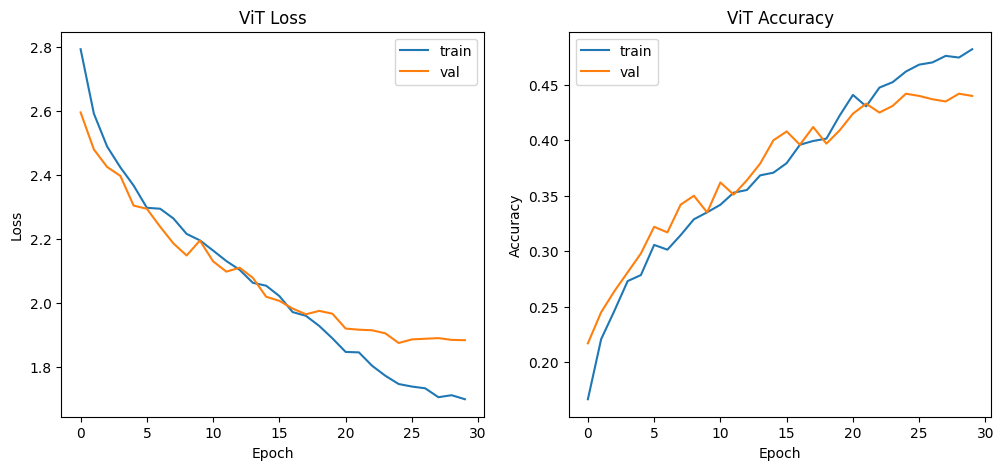

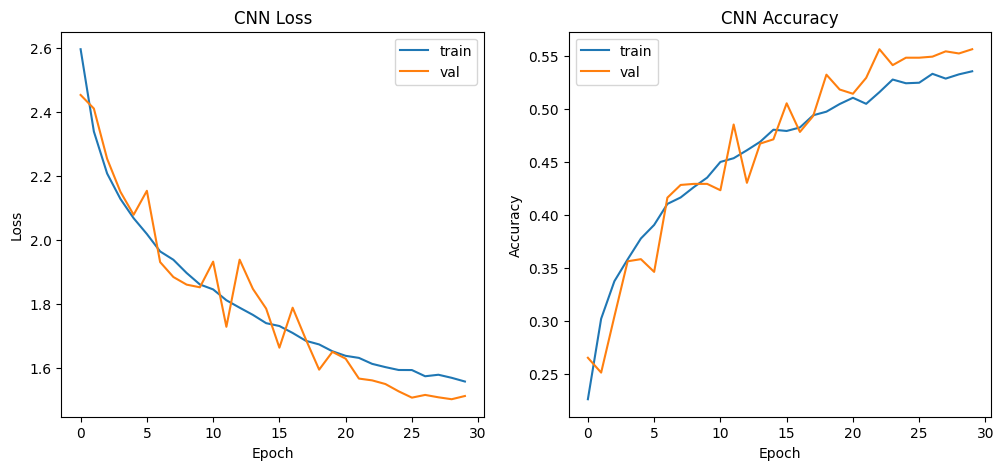

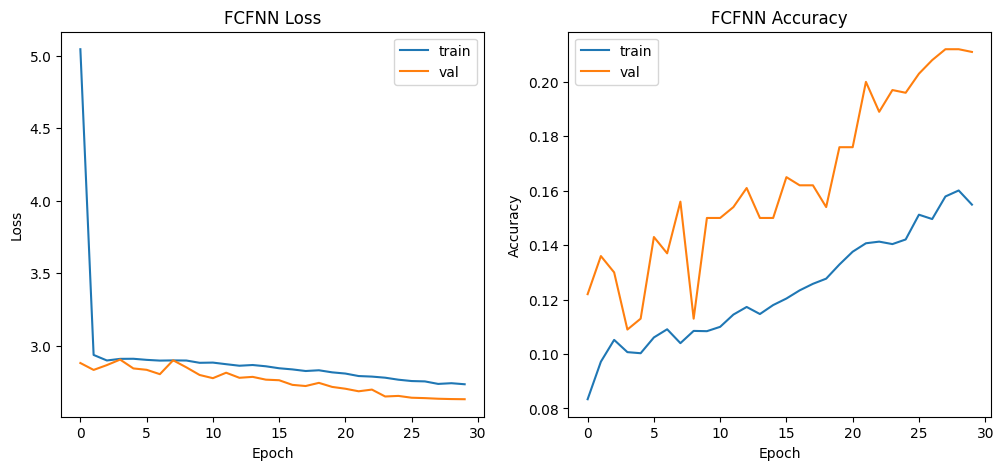

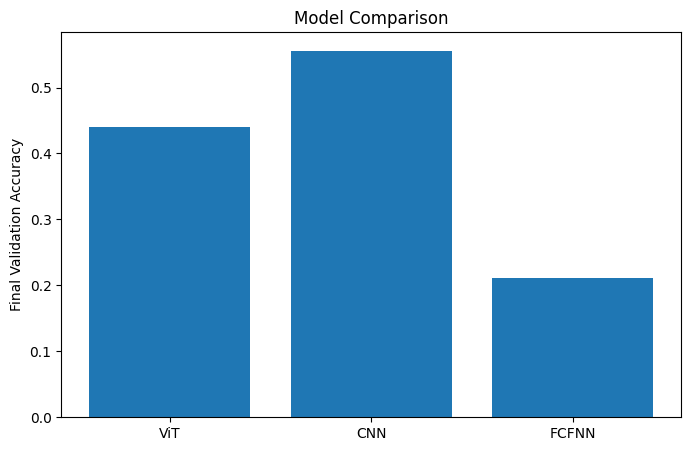

In [9]:
# -----------------------------
# Plot curves & final comparison
# -----------------------------
for model_name, h in histories.items():
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h["train_loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"{model_name} Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h["train_acc"], label="train")
    plt.plot(h["val_acc"], label="val")
    plt.title(f"{model_name} Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.show()

final_val_accs = {name: h["val_acc"][-1] for name, h in histories.items()}
plt.figure(figsize=(8,5))
plt.bar(final_val_accs.keys(), final_val_accs.values())
plt.ylabel("Final Validation Accuracy")
plt.title("Model Comparison")
plt.show()


In [10]:
final_accs = {}
for name, hist in histories.items():
    if "val_acc" in hist:
        final_accs[name] = hist["val_acc"][-1] * 100  # to percentage

# Pretty print
print("=== Final Validation Accuracies ===")
for name, acc in final_accs.items():
    print(f"{name:10s}: {acc:.2f}%")


=== Final Validation Accuracies ===
ViT       : 44.00%
CNN       : 55.60%
FCFNN     : 21.10%


In [11]:
for heads in [2,4,6,8]:
    vit = ViT(num_classes=20, embed_dim=384, depth=8,
              num_heads=heads, patch_size=16,
              patch_kind="conv", pos_kind="learned")
    name = f"ViT-h{heads}"
    histories[name] = run(vit, train_loader, val_loader, epochs=30, lr=1e-3, wd=1e-4)


[01] train 0.123 val 0.176 | loss 2.768
[02] train 0.161 val 0.175 | loss 2.742
[03] train 0.178 val 0.190 | loss 2.648
[04] train 0.179 val 0.186 | loss 2.719
[05] train 0.185 val 0.186 | loss 2.632
[06] train 0.172 val 0.163 | loss 2.801
[07] train 0.180 val 0.162 | loss 2.716
[08] train 0.180 val 0.199 | loss 2.598
[09] train 0.192 val 0.195 | loss 2.610
[10] train 0.204 val 0.200 | loss 2.623
[11] train 0.207 val 0.211 | loss 2.597
[12] train 0.201 val 0.206 | loss 2.591
[13] train 0.202 val 0.200 | loss 2.556
[14] train 0.215 val 0.219 | loss 2.525
[15] train 0.210 val 0.200 | loss 2.586
[16] train 0.215 val 0.234 | loss 2.521
[17] train 0.228 val 0.233 | loss 2.530
[18] train 0.231 val 0.240 | loss 2.489
[19] train 0.236 val 0.247 | loss 2.478
[20] train 0.238 val 0.242 | loss 2.461
[21] train 0.254 val 0.240 | loss 2.448
[22] train 0.255 val 0.263 | loss 2.417
[23] train 0.261 val 0.263 | loss 2.417
[24] train 0.259 val 0.271 | loss 2.397
[25] train 0.267 val 0.286 | loss 2.393


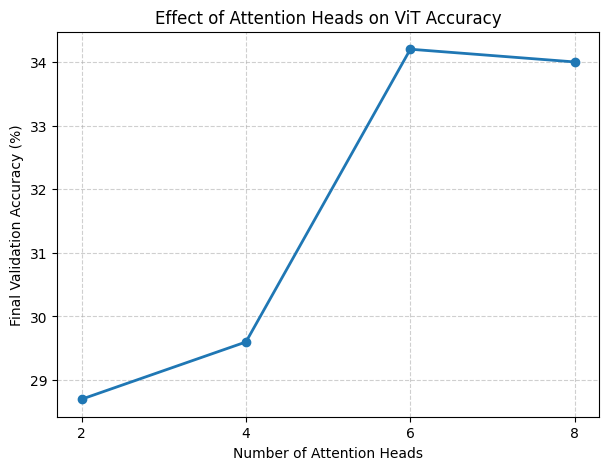

In [12]:
import matplotlib.pyplot as plt

# --- collect final accuracies ---
head_accs = {}
for heads in [2, 4, 6, 8]:
    name = f"ViT-h{heads}"
    head_accs[heads] = histories[name]["val_acc"][-1] * 100  # percentage

# --- plot ---
plt.figure(figsize=(7,5))
plt.plot(list(head_accs.keys()), list(head_accs.values()), marker="o", linewidth=2)

plt.title("Effect of Attention Heads on ViT Accuracy")
plt.xlabel("Number of Attention Heads")
plt.ylabel("Final Validation Accuracy (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks([2,4,6,8])
plt.show()


In [13]:
print("=== Final Validation Accuracies ===")

# CNN
print(f"CNN       : {histories['CNN']['val_acc'][-1]*100:.2f}%")

# FCFNN
print(f"FCFNN     : {histories['FCFNN']['val_acc'][-1]*100:.2f}%")

# ViTs with different heads
for heads in [2, 4, 6, 8]:
    name = f"ViT-h{heads}"
    print(f"{name:<9}: {histories[name]['val_acc'][-1]*100:.2f}%")


=== Final Validation Accuracies ===
CNN       : 55.60%
FCFNN     : 21.10%
ViT-h2   : 28.70%
ViT-h4   : 29.60%
ViT-h6   : 34.20%
ViT-h8   : 34.00%


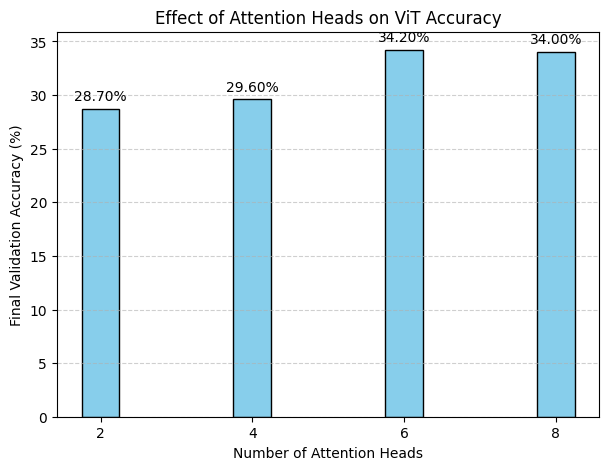

In [14]:
import matplotlib.pyplot as plt

# --- collect final accuracies ---
head_accs = {}
for heads in [2, 4, 6, 8]:
    name = f"ViT-h{heads}"
    head_accs[heads] = histories[name]["val_acc"][-1] * 100  # percentage

# --- bar chart ---
plt.figure(figsize=(7,5))
plt.bar(list(head_accs.keys()), list(head_accs.values()), width=0.5, color="skyblue", edgecolor="black")

plt.title("Effect of Attention Heads on ViT Accuracy")
plt.xlabel("Number of Attention Heads")
plt.ylabel("Final Validation Accuracy (%)")
plt.xticks([2,4,6,8])
plt.grid(axis="y", linestyle="--", alpha=0.6)

# annotate bars with values
for x, y in head_accs.items():
    plt.text(x, y+0.5, f"{y:.2f}%", ha="center", va="bottom", fontsize=10)

plt.show()
